In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from environment_batched import BatchedMarket, BatchedLeontief, BatchedFirm, BatchedEnvironment
from models.policy import BetaPolicyNetwork, DeterministicPolicyNetwork, BetaPolicyNetwork2
from models.critic import CentralizedCritic, CentralizedCritic2
from models.utils import get_state, get_state_dim, process_actions, get_action_dim
from trainer import TrainerAC, TrainerSAC, Trainer3
from utils.plotting import plot_actions, plot_environment


In [3]:

torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
device = 'cuda'
market_kwargs = dict(start_volumes=2,
                     base_price=50,
                     start_gains=100,
                     deprecation_steps=2,
                     max_price=100
                     )
prod_functions = [
    BatchedLeontief(torch.tensor([1, 0]), torch.tensor([0, 2]), device=device),
    BatchedLeontief(torch.tensor([0, 1]), torch.tensor([2, 0]), device=device),
]
invest_functions = [
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(2), device=device),
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(2), device=device),
]
env = BatchedEnvironment(market_kwargs,
                         BetaPolicyNetwork2,
                         prod_functions,
                         invest_functions=invest_functions,
                         production_reg=2,
                         batch_size=512)
critic = CentralizedCritic2
trainer = TrainerSAC(env,
                     q_critic=critic,
                     batch_size=512,
                     learning_rates=(3e-4, 3e-4),
                     buffer_size=8192 * 64,
                     entropy_reg=0.01,
                     entropy_gamma=0.99
                     )

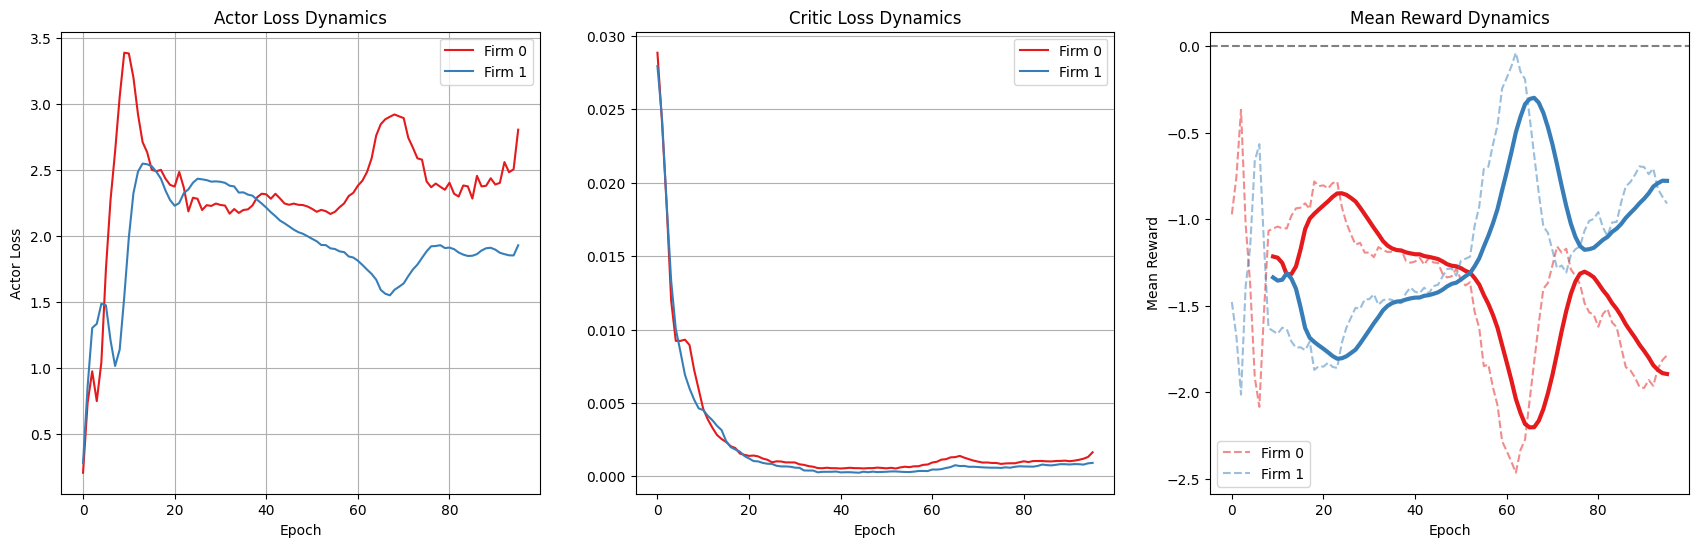

100%|██████████| 100/100 [01:22<00:00,  1.22it/s, LR=0.000182, Buffer Index=65536, Order=[0, 1]]


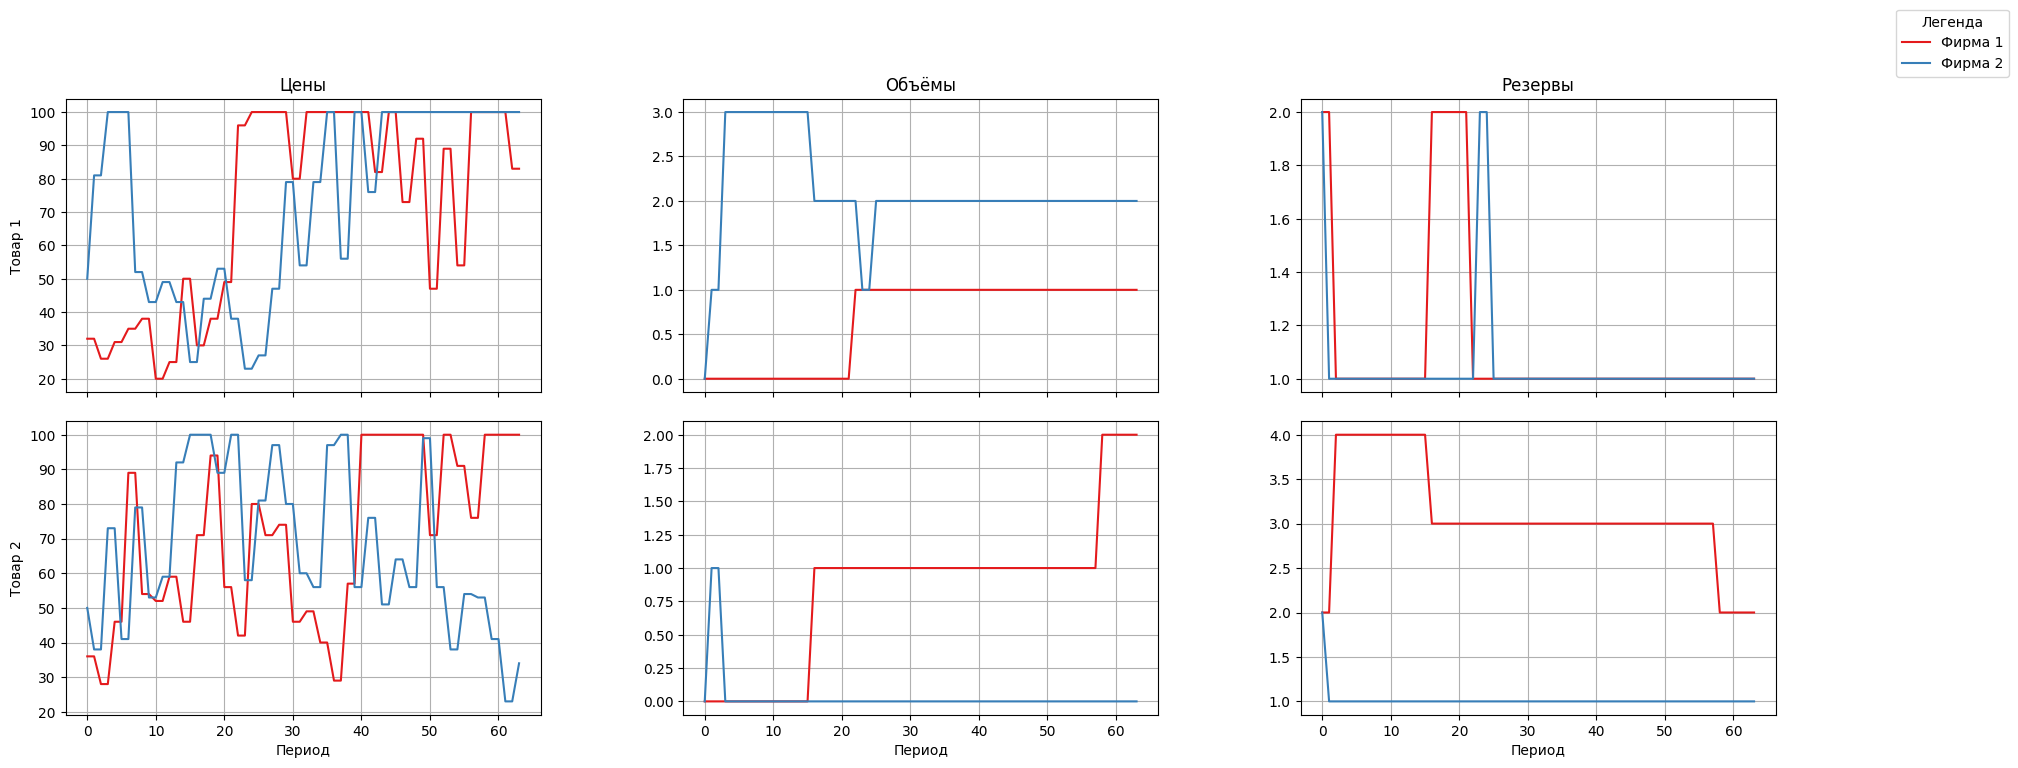

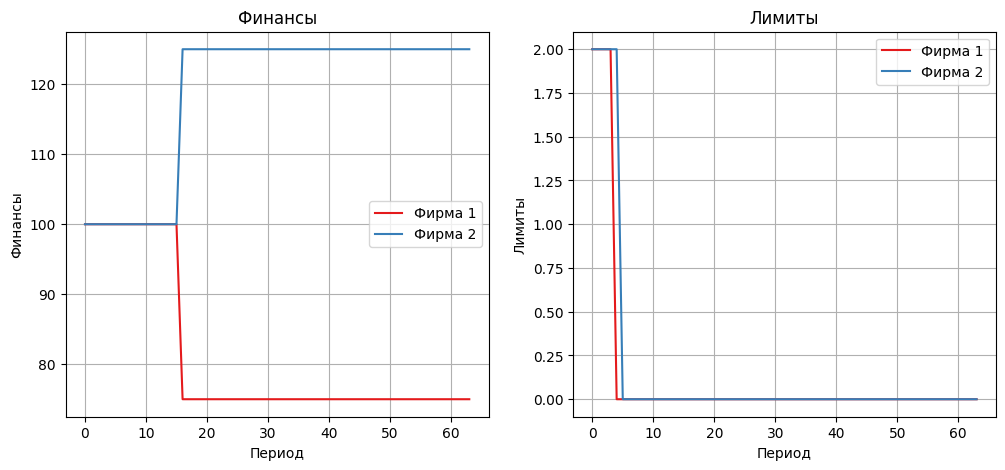

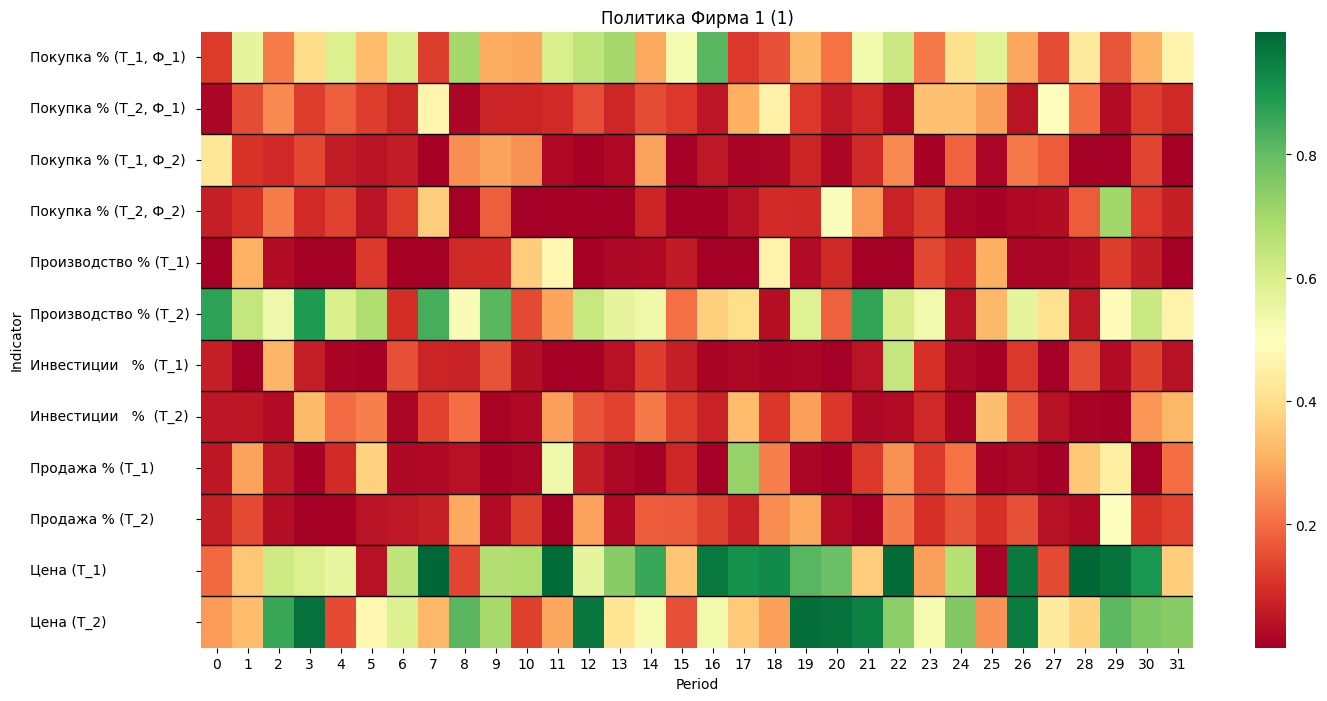

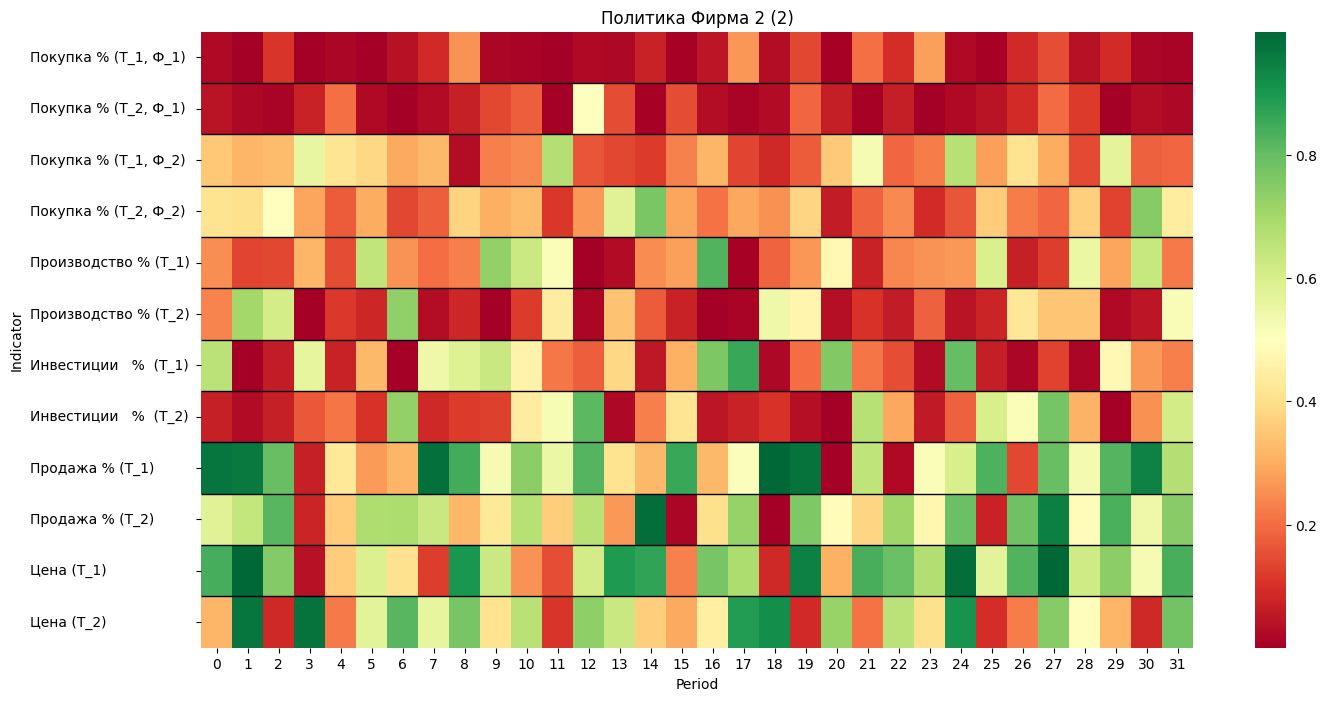

In [4]:
trainer.train(300, episode_length=32)

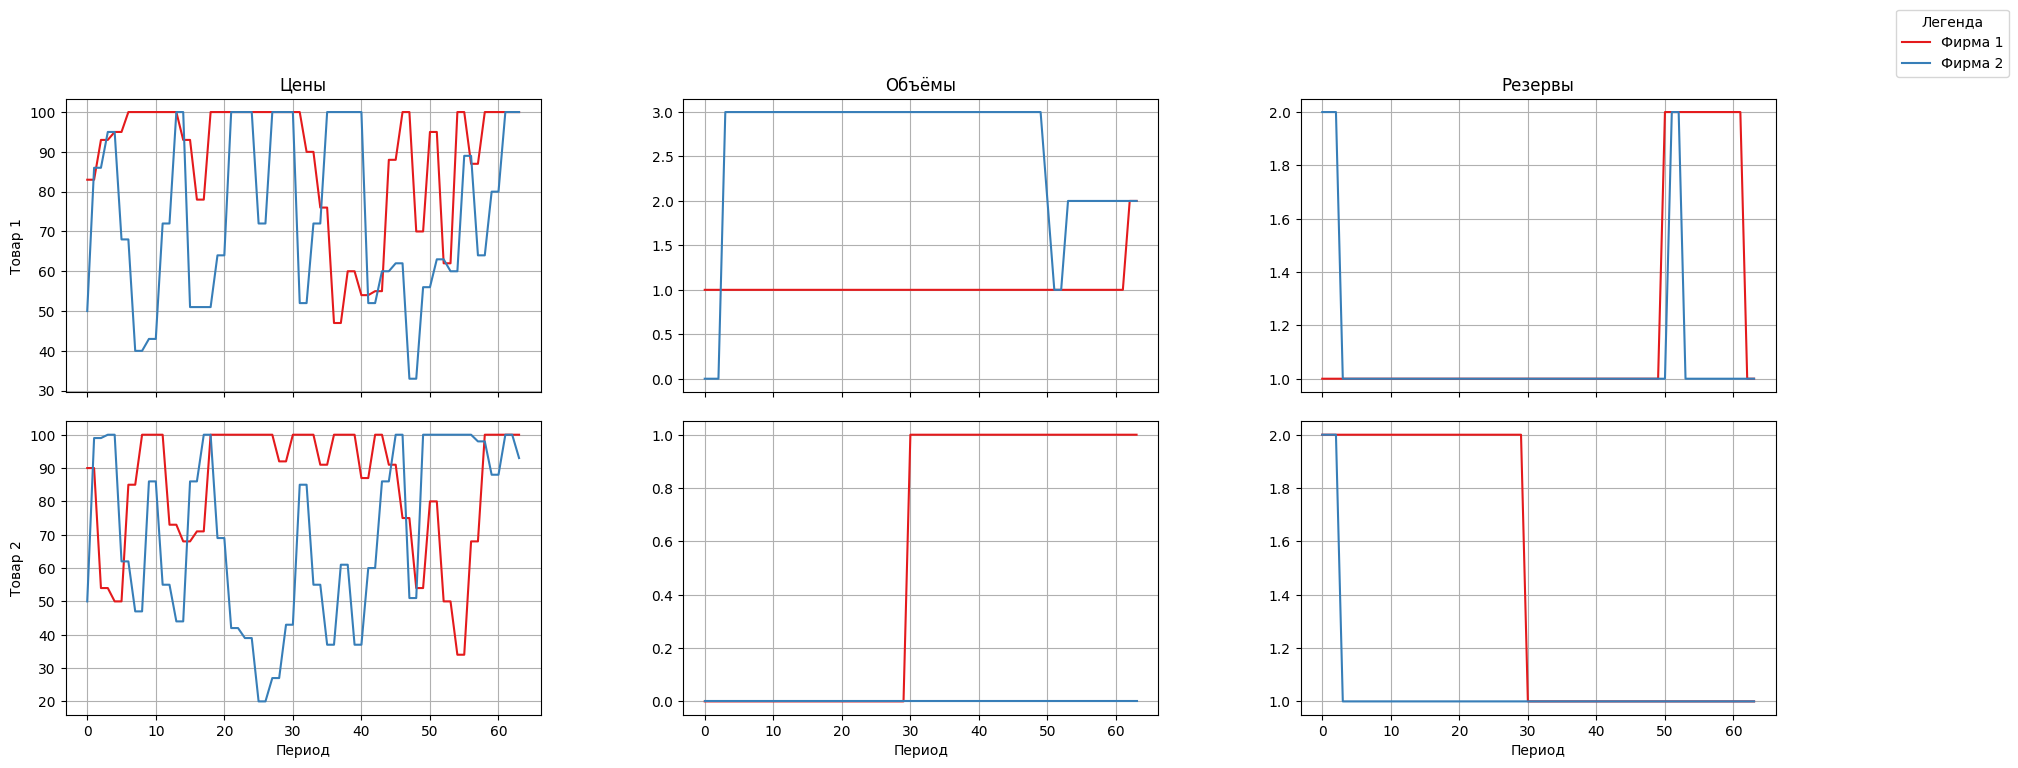

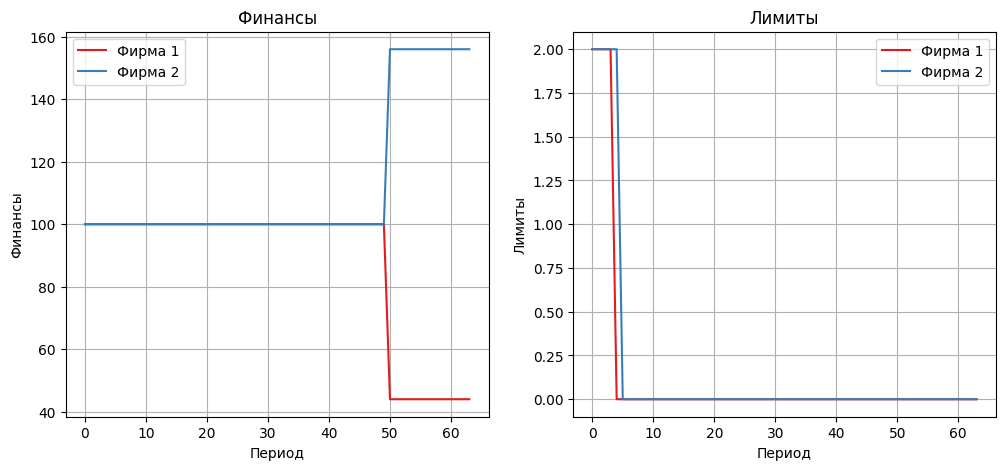

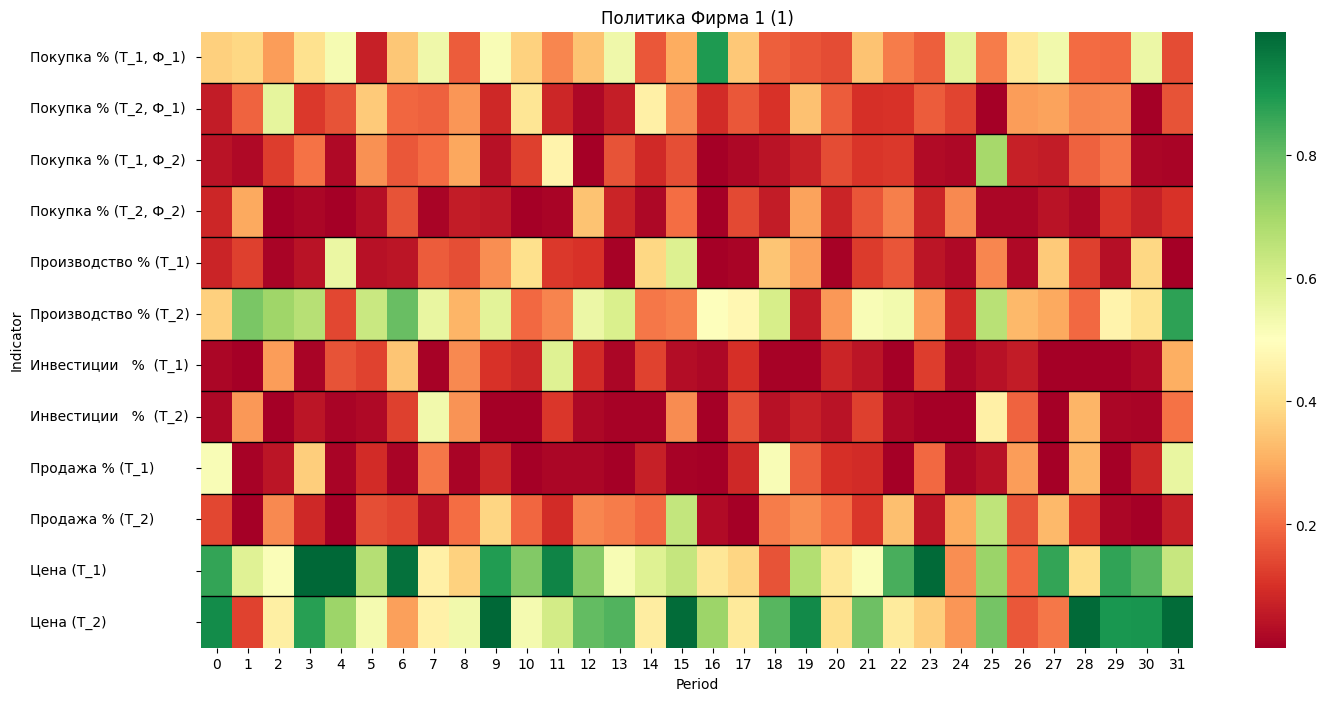

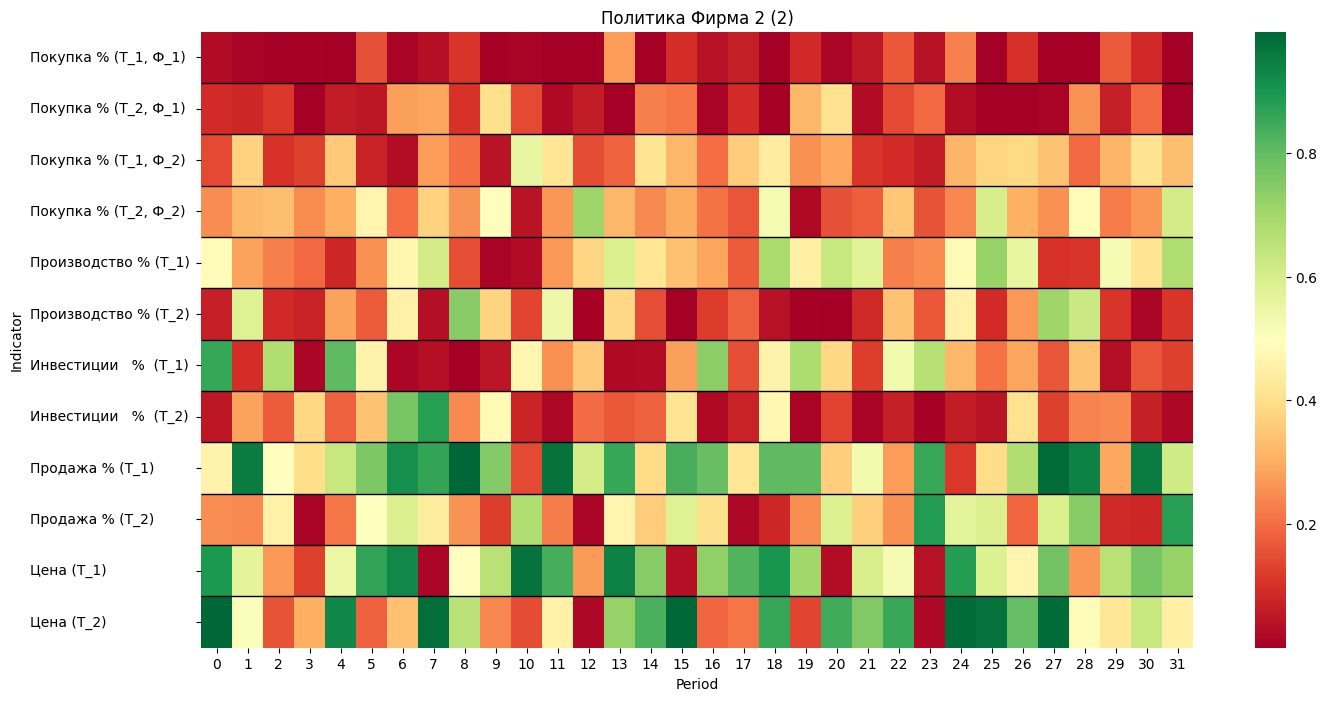

In [5]:
#
env.change_batch_size(1)
env.reset()
n_periods = 64
for i in range(n_periods):
    env.step_and_record(i % env.market.n_firms)
plot_environment(env.state_history)
plot_actions(env.actions_history[0], 'Политика Фирма 1 (1)')
plot_actions(env.actions_history[1], 'Политика Фирма 2 (2)')

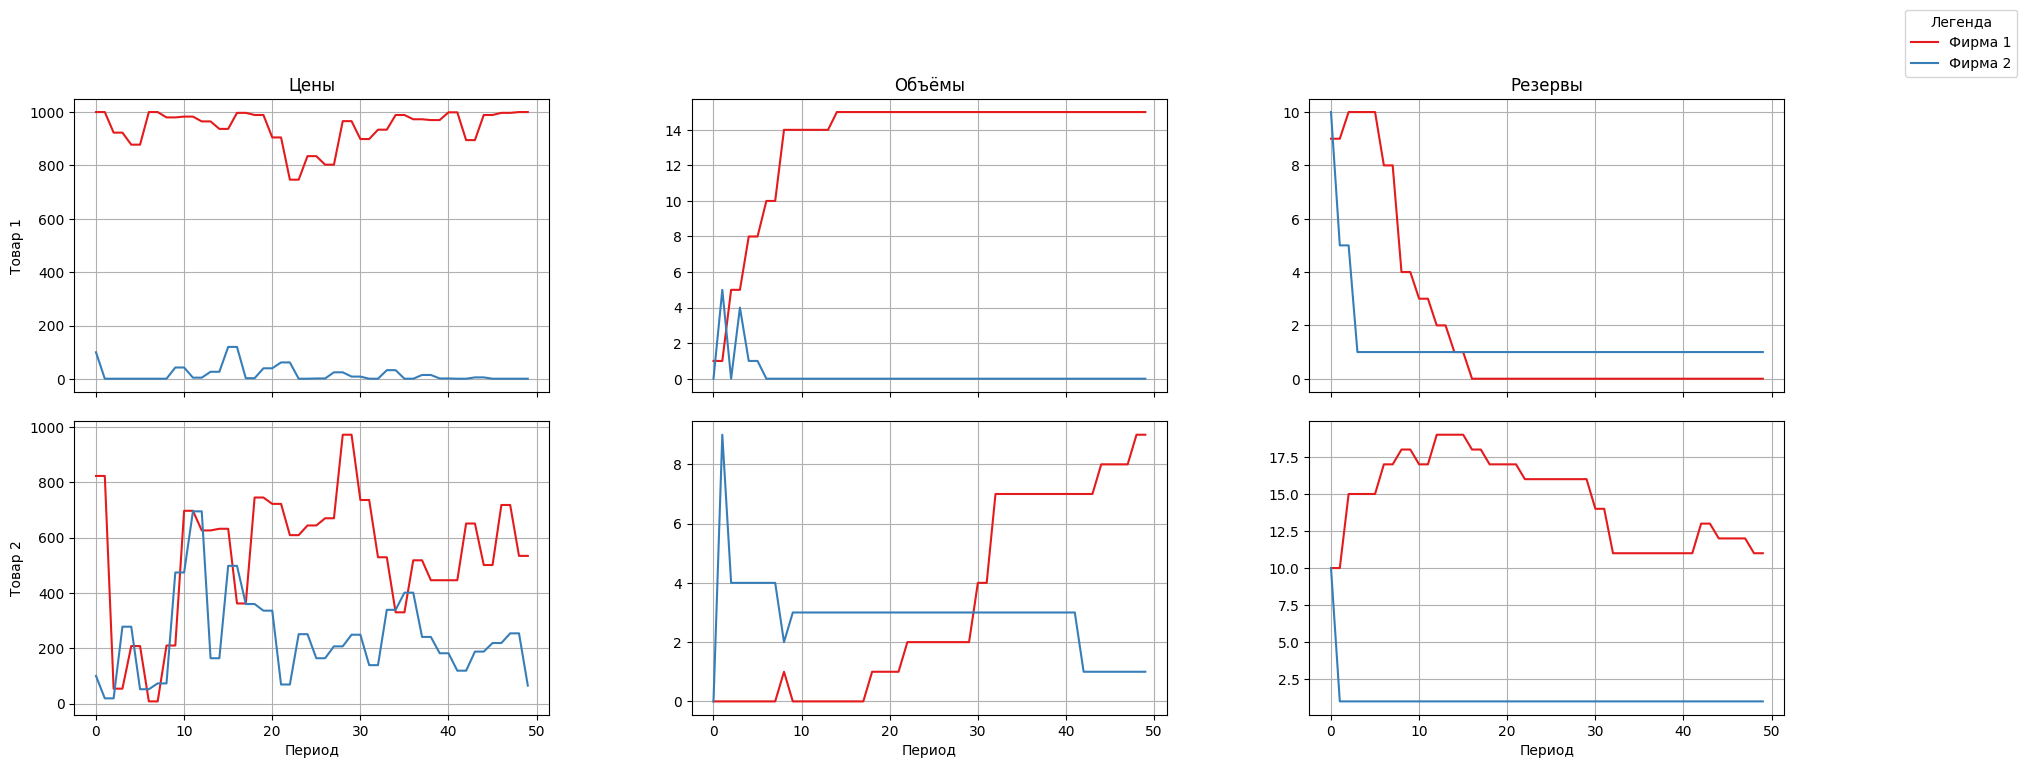

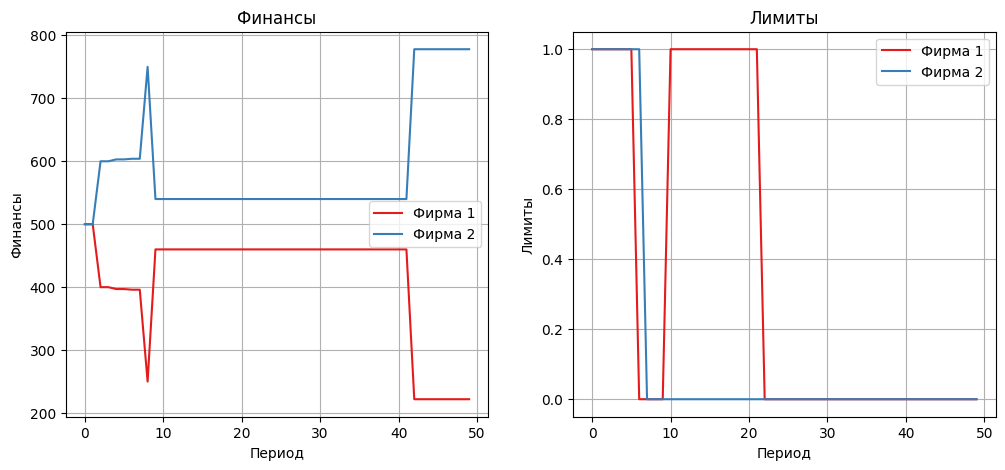

In [13]:
from utils.plotting import plot_actions, plot_environment

plot_environment(env.state_history)

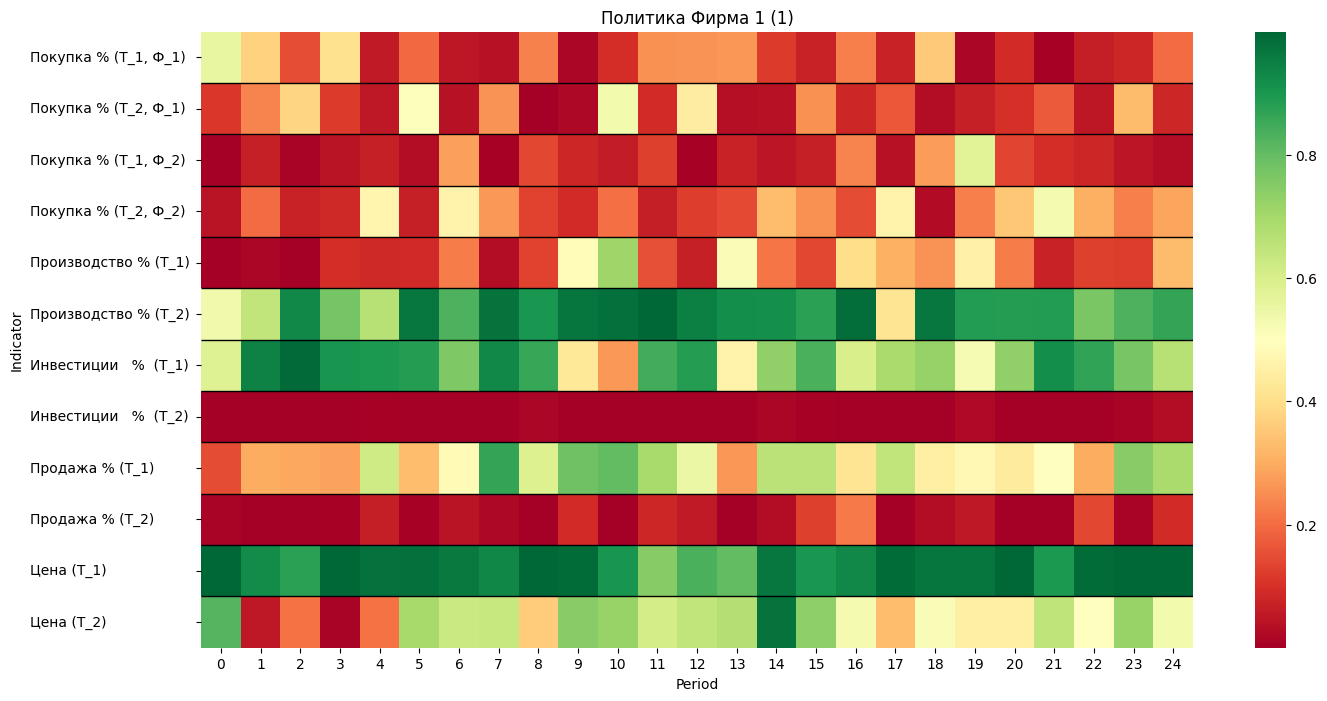

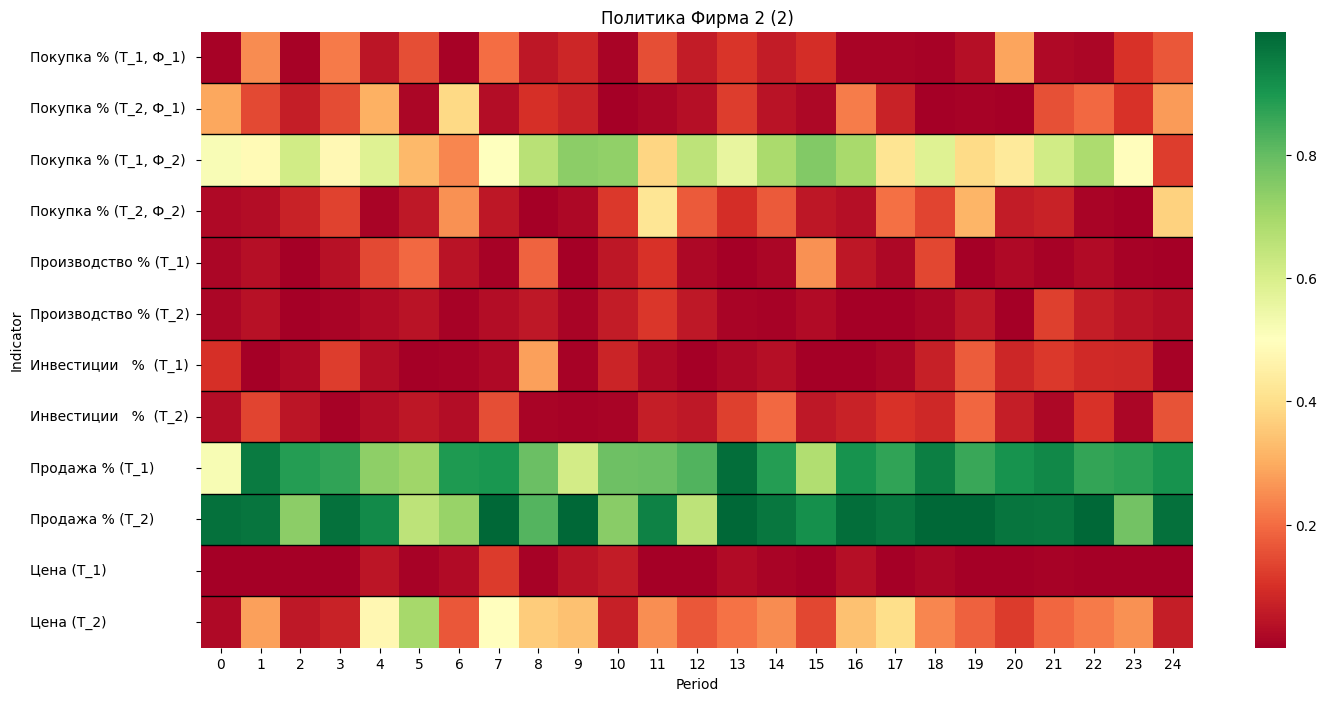

In [14]:
plot_actions(env.actions_history[0], 'Политика Фирма 1 (1)')
plot_actions(env.actions_history[1], 'Политика Фирма 2 (2)')

In [298]:
trainer.train(1000, episode_length=50)

  0%|                                                           | 1/1000 [00:02<49:32,  2.98s/it, LR=3.5107492673734235e-05]


KeyboardInterrupt: 

In [111]:
env.reset()
env.market

Market(n_firms: 2, n_commodities: 2)
	Volume Matrix:
tensor([[10, 10],
        [10, 10]], device='cuda:0')
	Price Matrix:
tensor([[100, 100],
        [100, 100]], device='cuda:0')
	Gain Matrix:
tensor([100, 100], device='cuda:0')

In [112]:
env.firms

[Firm id: 0
 Reserves: [0, 0]
 Finance: 0
 Limit: 1
 Capital: tensor([2]),
 Firm id: 1
 Reserves: [0, 0]
 Finance: 0
 Limit: 1
 Capital: tensor([2])]

In [179]:
for i in range(5):
    state, actions_concatenated, log_probs_concatenated, revenue, costs = env.step(i % market.n_firms)
env.market

Market(n_firms: 2, n_commodities: 2)
	Volume Matrix:
tensor([[11, 25],
        [ 0,  0]], device='cuda:0')
	Price Matrix:
tensor([[199, 199],
        [ 84, 199]], device='cuda:0')
	Gain Matrix:
tensor([0, 0], device='cuda:0')

In [180]:
env.firms

[Firm id: 0
 Reserves: [1, 1]
 Finance: 64
 Limit: 0
 Capital: tensor([], dtype=torch.int64),
 Firm id: 1
 Reserves: [1, 0]
 Finance: 136
 Limit: 0
 Capital: tensor([], dtype=torch.int64)]

In [23]:
percent_to_buy, percent_to_sale, percent_to_use, percent_price_change = map(lambda x: x.tolist(), torch.split(actions_concatenated, [market.n_firms * 2, market.n_firms * 2, 2, 2]))
percent_to_buy, percent_to_sale, percent_to_use, percent_price_change

RuntimeError: split_with_sizes expects split_sizes to sum exactly to 13 (input tensor's size at dimension 0), but got split_sizes=[4, 4, 2, 2]

In [685]:
env.market

Market(n_firms: 4, n_commodities: 2)
	Volume Matrix:
tensor([[100,   2],
        [  0,   0],
        [  0,   0],
        [  0,   0]])
	Price Matrix:
tensor([[149,  45],
        [  2,  29],
        [ 15,   8],
        [  1, 999]])
	Gain Matrix:
tensor([0, 0, 0, 0])

In [246]:
env.firms[0]

Firm id: 0
Reserves: [1, 1]
Finance: 862

In [247]:
env.firms[1]

Firm id: 1
Reserves: [1, 1]
Finance: 4657

In [248]:
env.firms[2]

Firm id: 2
Reserves: [1, 1]
Finance: 1979

In [249]:
env.firms[3]

Firm id: 3
Reserves: [1, 1]
Finance: 502